# 4D change analysis of near-continuous LiDAR time series for applications in geomorphic monitoring

## Time series-based change analysis of surface dynamics at a sandy beach

In this notebook we will show how to perform time series-based surface change analysis on a time series of permanent TLS point clouds of the sandy beach at Kijkduin for a timespan of around 6 months (<a href="#references">Vos et al., 2022</a>). 

The objective is to assess surface dynamics using Principal Component Analysis (PCA; following Frantzen et al., 2023). Look into the related article for comparison of possible surface dynamics of the use case and help for deciding on suitable parameters, etc.

This notebook is based on a [short course](https://github.com/tum-rsa/vgc2023-shortcourse-4d/tree/main) given at the [Virtual Geoscience Conference 2023](https://vgc-series.org/) by Katharina Anders, Roderik Lindenbergh, and Mieke Kuschnerus.


## Software and data
This task is solved using Python with the [`py4dgeo`](https://github.com/3dgeo-heidelberg/py4dgeo) library. The workflow is  introduced throughout this notebook. Also, make use of the software documentations!

You can use [CloudCompare](../../../software/software_cloudcompare.md) or GIS Software (e.g., [QGIS](../../../software/software_qgis.md)) to check the data and visualize your results.

The dataset is a subsampled version of the original time series, using 12-hourly epochs of point clouds and spatial subsampling to 50 cm. In the data directory `kijkduin`, you find the prepared input point clouds and a core points point cloud, which is manually cleaned from noise.

## Loading data and calculation of surface changes

Prepare the analysis by compiling the list of files (epochs) and read the timestamps from the file names (format `YYMMDD_hhmmss`) into `datetime` objects. Use the point cloud files and timestamps to create a py4dgeo `SpatiotemporalAnalysis` object. For this you need to instantiate the M3C2 algorithm. You can use the point cloud file `170115_150816_aoi_50cm.laz` as core points. Explore the point cloud properties in CloudCompare: 

* Considering the available point density and surface characteristics, what would be a suitable cylinder radius for the distance calculation?
* What would be a suitable approach to derive the surface normals in this topography and expected types of surface changes?

Hint: In this flat topography and predominant provess of sand deposition and erosion, it can be suitable to orient the normals purely vertically. In this case, they do not need to be computed, and you can [customize the py4dgeo algorithm](https://py4dgeo.readthedocs.io/en/latest/customization.html#Changing-search-directions) accordingly.

Use the first point cloud in the time series (list of files) as reference epoch. You can assume a registration error of 1.9 cm for the M3C2 distance calculation (cf. <a href="#references">Vos et al., 2022</a>).

Explore the spatiotemporal change information by visualizing the changes at a selected epoch and visualizing the time series at a selected location. 

<span style="color:blue">First, we start by setting up the Python environment and data:</span>

In [1]:
# import required modules
import os
import numpy as np
import py4dgeo
from datetime import datetime

# specify the data path
data_path = 'path-to-data'

# check if the specified path exists
if not os.path.isdir(data_path):
    print(f'ERROR: {data_path} does not exist')
    print('Please specify the correct path to the data directory by replacing <path-to-data> above.')

# sub-directory containing the point clouds
pc_dir = os.path.join(data_path, 'pointclouds')

# list of point clouds (time series)
pc_list = os.listdir(pc_dir)
pc_list[:5] # print the first elements

['kijkduin_170117_120041.laz',
 'kijkduin_170118_000050.laz',
 'kijkduin_170120_120036.laz',
 'kijkduin_170121_000046.laz',
 'kijkduin_170121_120055.laz']

<span style="color:blue">In the list of point cloud files you can see that we have one laz file per epoch available. The file name contains the timestamp of the epoch, respectively, in format `YYMMDD_hhmmss`. To use this information for our analysis, we read the timestamp information from the file names into `datetime` objects.</span> 

In [2]:
# read the timestamps from file names
timestamps = []
for f in pc_list:
    if not f.endswith('.laz'):
        continue

    # get the timestamp from the file name
    timestamp_str = '_'.join(f.split('.')[0].split('_')[1:]) # yields YYMMDD_hhmmss

    # convert string to datetime object
    timestamp = datetime.strptime(timestamp_str, '%y%m%d_%H%M%S')
    timestamps.append(timestamp)

timestamps[:5]

[datetime.datetime(2017, 1, 17, 12, 0, 41),
 datetime.datetime(2017, 1, 18, 0, 0, 50),
 datetime.datetime(2017, 1, 20, 12, 0, 36),
 datetime.datetime(2017, 1, 21, 0, 0, 46),
 datetime.datetime(2017, 1, 21, 12, 0, 55)]

<span style="color:blue">Now we use the point cloud files and timestamp information to create a `SpatiotemporalAnalysis` object</span> 

In [ ]:
analysis = py4dgeo.SpatiotemporalAnalysis(f'{data_path}/kijkduin.zip', force=True)

<span style="color:blue">As reference epoch, we use the first epoch in our time series:</span> 

In [ ]:
# specify the reference epoch
reference_epoch_file = os.path.join(pc_dir, pc_list[0])

# read the reference epoch and set the timestamp
reference_epoch = py4dgeo.read_from_las(reference_epoch_file)
reference_epoch.timestamp = timestamps[0]

# set the reference epoch in the spatiotemporal analysis object
analysis.reference_epoch = reference_epoch

<span style="color:blue">For epochs to be added, we now configure the M3C2 algorithm to derive the change values. We would like to set the normals purely vertically, so we define a customized computation of cylinder `directions`:</span> 

In [5]:
# Inherit from the M3C2 algorithm class to define a custom direction algorithm
class M3C2_Vertical(py4dgeo.M3C2):
    def directions(self):
        return np.array([0, 0, 1]) # vertical vector orientation

# specify corepoints, here all points of the reference epoch
analysis.corepoints = reference_epoch.cloud[::]

# specify M3C2 parameters for our custom algorithm class
analysis.m3c2 = M3C2_Vertical(cyl_radii=(1.0,), max_distance=10.0, registration_error = 0.019)

[2023-09-16 16:21:10][INFO] Initializing Epoch object from given point cloud
[2023-09-16 16:21:10][INFO] Building KDTree structure with leaf parameter 10
[2023-09-16 16:21:10][INFO] Saving epoch to file 'C:\Users\katha\AppData\Local\Temp\tmpqh8sxujg\corepoints.zip'


<span style="color:blue">Now we add all the other epochs with their timestamps:</span> 

In [ ]:
# create a list to collect epoch objects
epochs = []
for e, pc_file in enumerate(pc_list[1:]):
    epoch_file = os.path.join(pc_dir, pc_file)
    epoch = py4dgeo.read_from_las(epoch_file)
    epoch.timestamp = timestamps[e]
    epochs.append(epoch)

# add epoch objects to the spatiotemporal analysis object
analysis.add_epochs(*epochs)

# print the spatiotemporal analysis data for 3 corepoints and 5 epochs, respectively
print(f"Space-time distance array:\n{analysis.distances[:3,:5]}")
print(f"Uncertainties of M3C2 distance calculation:\n{analysis.uncertainties['lodetection'][:3, :5]}")
print(f"Timestamp deltas of analysis:\n{analysis.timedeltas[:5]}")

<span style="color:blue">We visualize the changes in the scene for a selected epoch, together with the time series of surface changes at a selected location. The location here was selected separately in CloudCompare (as the corepoint id).</span> 

[2023-09-16 16:23:35][INFO] Restoring epoch from file 'C:\Users\katha\AppData\Local\Temp\tmpd09sukp0\reference_epoch.zip'


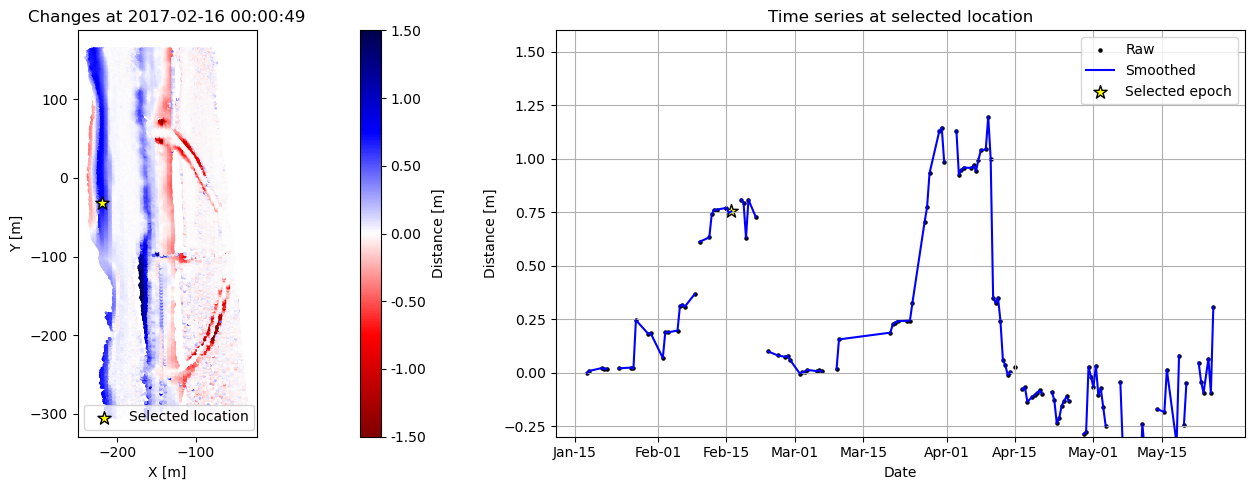

In [7]:
cp_idx_sel = 15162 # selected core point index
epoch_idx_sel = 28 # selected epoch index

# import plotting module
import matplotlib.pyplot as plt

# allow interactive rotation in notebook
%matplotlib inline

# create the figure
fig=plt.figure(figsize=(15,5))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)

# get the corepoints
corepoints = analysis.corepoints.cloud

# get change values of last epoch for all corepoints
distances = analysis.distances
distances_epoch = [d[epoch_idx_sel] for d in distances] 

# get the time series of changes at a specific core point locations
coord_sel = analysis.corepoints.cloud[cp_idx_sel]
timeseries_sel = distances[cp_idx_sel]

# get the list of timestamps from the reference epoch timestamp and timedeltas
timestamps = [t + analysis.reference_epoch.timestamp for t in analysis.timedeltas]

# plot the scene
d = ax1.scatter(corepoints[:,0], corepoints[:,1], c=distances_epoch[:], cmap='seismic_r', vmin=-1.5, vmax=1.5, s=1, zorder=1) 
plt.colorbar(d, format=('%.2f'), label='Distance [m]', ax=ax1, pad=.15)

# add the location of the selected coordinate
ax1.scatter(coord_sel[0], coord_sel[1], facecolor='yellow', edgecolor='black', s=100, zorder=2, label='Selected location', marker='*')
ax1.legend()

# configure the plot layout
ax1.set_xlabel('X [m]')
ax1.set_ylabel('Y [m]')
ax1.set_aspect('equal')
ax1.set_title('Changes at %s' % (analysis.reference_epoch.timestamp+analysis.timedeltas[epoch_idx_sel]))

# plot the time series
ax2.scatter(timestamps, timeseries_sel, s=5, color='black', label='Raw')
ax2.plot(timestamps, timeseries_sel, color='blue', label='Smoothed')
ax2.set_xlabel('Date')

# add the epoch of the plotted scene
ax2.scatter(timestamps[epoch_idx_sel], timeseries_sel[epoch_idx_sel], facecolor='yellow', marker='*', edgecolor='black', s=100, color='red', label='Selected epoch')
ax2.legend()

# format the date labels
import matplotlib.dates as mdates
dtFmt = mdates.DateFormatter('%b-%d') 
plt.gca().xaxis.set_major_formatter(dtFmt) 

# configure the plot layout
ax2.set_ylabel('Distance [m]')
ax2.grid()
ax2.set_ylim(-0.3,1.6)
ax2.set_title('Time series at selected location')

plt.tight_layout()
plt.show()

<span style="color:blue">The map of changes in the scene shows us linear structures of sand deposition near the coast which can be interpreted as sand bars (with knowledge about coastal processes). This is confirmed by the surface behavior over time, expressed in the time series plot. However, the time series is quite noisy especially in this part of the beach, which is regularly covered by water during high tides (leading to missing data) and also varies strongly in surface moisture (influencing the LiDAR range measurement and causing noise). We therefore continue with temporal smoothing of the time series.</span>

## Temporal smoothing

You are dealing with a temporal subset of the original hourly time series. The effect of temporal measurement variability may therefore be less pronounced (compared to the assessment in, e.g., [Anders et al., 2019](#references)). Nonetheless, you may apply temporal smoothing to reduce the influence of noise on your change analysis using a rolling median averaging of one week. This will also fill possible gaps in your data, e.g., lower ranges during poor atmospheric conditions or no data due to water coverage during tides on the lower beach part. 

Visualize the raw and smoothed change values in the time series of your selected location.

<span style="color:blue">We apply a rolling median with a defined temporal window of 14 epochs (corresponding to one week of 12-hourly point clouds) using the `temporal_averaging()` function in py4dgeo.</span> 

In [8]:
analysis.smoothed_distances = py4dgeo.temporal_averaging(analysis.distances, smoothing_window=14)

[2023-09-16 16:23:44][INFO] Starting: Smoothing temporal data


C:\Users\katha\.conda\envs\vgc2023\Lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


[2023-09-16 16:24:06][INFO] Finished in 21.4174s: Smoothing temporal data


<span style="color:blue">Now we can compare the raw and smoothed time series at our selected location:</span> 

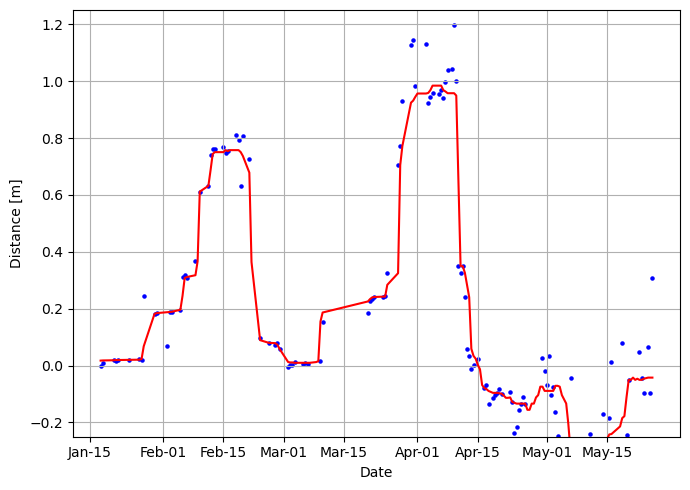

In [9]:
# create the figure
fig, ax = plt.subplots(1,1,figsize=(7,5))

# plot the raw time series
ax.scatter(timestamps, timeseries_sel, color='blue', label='raw', s=5)

# plot the smoothed time series
timeseries_sel_smooth = analysis.smoothed_distances[cp_idx_sel]
ax.plot(timestamps, timeseries_sel_smooth, color='red', label='smooth')

# format the date labels
import matplotlib.dates as mdates
dtFmt = mdates.DateFormatter('%b-%d') 
plt.gca().xaxis.set_major_formatter(dtFmt) 

# add plot elements
ax.set_xlabel('Date')
ax.set_ylabel('Distance [m]')
ax.grid()
ax.set_ylim(-.25,1.25)

plt.tight_layout()
plt.show()

<span style="color:blue">From the smoothed time series at the selected location, we can now much better interpret the surface behavior. In fact, we can distinctly observe that there were two consecutive occurrences of temporary deposition of several weeks. These represent two phases where sand bars are present. They can be extracted as individual objects by the 4D objects-by-change method. Before, we continue with time series clustering and the assessment of overall change patterns in the following.</span> 

## Principal component analysis

In the following, we will use principal component analysis (PCA; also referred to as empirical orthogonal functions) as a tool to summarize the change patterns within a spatiotemporal dataset. The method is based on [this master thesis](http://resolver.tudelft.nl/uuid:ce98c4e3-6ca1-4966-a5cf-2120f2fa44bf), to be published in [Frantzen et al. (2023)](#references). 
 
For this technique, the 4D data shall be represented as a two-dimensional array in which the rows correspond to different epochs, and the columns correspond to each individual [x, y] coordinate where a z or surface change value is represented. 

Reshape the data from the `SpatiotemporalAnalysis` object so that all coordinates are represented in one axis, i.e. an array holding [time, space]:

In [13]:
X = distances.transpose()

Find coordinates without nan values, and create a new array without nan values:

In [14]:
idxs = np.argwhere(~np.isnan(X).any(axis=0)) # store the column indices where actual data is present
X_no_nan = X[:,idxs.flatten()].reshape((X.shape[0],-1))

Compute the loading and scores of the prinicpal components in 'NaN-free' X:

In [15]:
from sklearn.decomposition import PCA
pca = PCA()
scores = pca.fit_transform(X_no_nan)
result = pca.components_

Plot the principal component loadings and scores along with their fraction of explained variance:

C:\Users\katha\AppData\Local\Temp\ipykernel_2460\1218017098.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


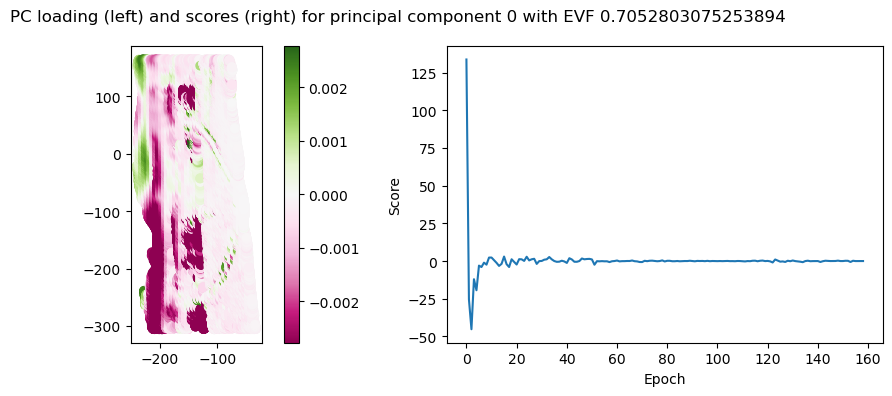

In [16]:
coords_no_nan = analysis.corepoints.cloud[idxs]
for i in range(1): #range(pca.n_components_):
    fig, axes = plt.subplots(1,2, figsize=(10, 4))
    sat_val = np.abs(np.nanpercentile(result[i], 10)) + np.abs(np.nanpercentile(result[i], 90)) / 2
    s = axes[0].scatter(coords_no_nan[:,0,0], coords_no_nan[:,0,1], c=result[i], clim=(-sat_val,sat_val), cmap='PiYG')
    axes[0].set_aspect('equal')
    axes[1].plot(scores[i])
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Score')
    fig.suptitle(f'PC loading (left) and scores (right) for principal component {i} with EVF {pca.explained_variance_ratio_[i]}')
    plt.colorbar(s, ax=axes[0])
    plt.tight_layout()
    fig.show()

<a id='references'></a>
# References

* Anders, K., Lindenbergh, R. C., Vos, S. E., Mara, H., de Vries, S., & Höfle, B. (2019). High-Frequency 3D Geomorphic Observation Using Hourly Terrestrial Laser Scanning Data Of A Sandy Beach. ISPRS Ann. Photogramm. Remote Sens. Spatial Inf. Sci., IV-2/W5, pp. 317-324. doi: [10.5194/isprs-annals-IV-2-W5-317-2019](https://doi.org/10.5194/isprs-annals-IV-2-W5-317-2019).
* Anders, K., Winiwarter, L., Mara, H., Lindenbergh, R., Vos, S. E., & Höfle, B. (2021). Fully automatic spatiotemporal segmentation of 3D LiDAR time series for the extraction of natural surface changes. ISPRS Journal of Photogrammetry and Remote Sensing, 173, pp. 297-308. doi: [10.1016/j.isprsjprs.2021.01.015](https://doi.org/10.1016/j.isprsjprs.2021.01.015).
* Frantzen, P., Voordendag, A., Kuschnerus, M., Rutzinger, M.,  Wouters, B., Lindenbergh, R. (2023, in review). Identifying Paraglacial Geomorphic Process Dynamics Using A Principal Component Analysis Of Terrestrial Laser Scanning Time Series.
* Vos, S., Anders, K., Kuschnerus, M., Lindenberg, R., Höfle, B., Aarnikhof, S. & Vries, S. (2022). A high-resolution 4D terrestrial laser scan dataset of the Kijkduin beach-dune system, The Netherlands.  Scientific Data, 9:191. doi: [10.1038/s41597-022-01291-9](https://doi.org/10.1038/s41597-022-01291-9).